In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [3]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests


In [4]:
df= pd.read_excel("AirQualityUCI.xlsx")

In [5]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


DataPreprocessing

In [6]:
df["Date"] =df["Date"].astype(str)
df["Time"] =df["Time"].astype(str)
df["Datetime"] = df["Date"]+ " " + df["Time"]
# To make datetime into one column 

In [7]:
df = df.drop(["Date",'Time'], axis=1)


In [8]:
df.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH', 'Datetime'],
      dtype='object')

In [9]:
((df==-200).sum() / len(df)) * 100

CO(GT)           17.986534
PT08.S1(CO)       3.911510
NMHC(GT)         90.231912
C6H6(GT)          3.911510
PT08.S2(NMHC)     3.911510
NOx(GT)          17.516298
PT08.S3(NOx)      3.911510
NO2(GT)          17.548360
PT08.S4(NO2)      3.911510
PT08.S5(O3)       3.911510
T                 3.911510
RH                3.911510
AH                3.911510
Datetime          0.000000
dtype: float64

In [10]:
# since 90% of the data in NMHC(GT) is empty, we'll just drop that column
#  rest all we'll fill up the data using interpolation or upward fill

In [11]:
(df["NMHC(GT)"]== -200).sum()

8443

In [12]:
df=df.drop("NMHC(GT)", axis=1)

In [13]:
df.replace(-200, np.nan, inplace=True)
# replacing -200 - given as an alias for null in the assignment

In [14]:
df.isna().sum()

CO(GT)           1683
PT08.S1(CO)       366
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
Datetime            0
dtype: int64

In [15]:
df1 = df.copy()
# taking a copy to perform other opertations

In [16]:
df1.dropna(subset= ["PT08.S1(CO)"],inplace=True)

In [17]:
df1.isna().sum()

CO(GT)           1647
PT08.S1(CO)         0
C6H6(GT)            0
PT08.S2(NMHC)       0
NOx(GT)          1595
PT08.S3(NOx)        0
NO2(GT)          1598
PT08.S4(NO2)        0
PT08.S5(O3)         0
T                   0
RH                  0
AH                  0
Datetime            0
dtype: int64

Datavisuailisation to check before gap filling

In [18]:
# plt.plot(df1["Datetime"],df1["CO(GT)"])
# plt.plot(df1["Datetime"],df1["NOx(GT)"])
# plt.plot(df1["Datetime"],df1["NO2(GT)"])

In [19]:
df1[['CO(GT)', 'NOx(GT)', 'NO2(GT)']] = df1[['CO(GT)', 'NOx(GT)', 'NO2(GT)']].interpolate(method='linear', limit_direction='both')
# since our data is time measurement, interpolation makes the most sense, preferref over mean/mode filling because this wont cause sudden jumps. and linear method was chosen adn the gaps are small

In [20]:
df1.isna().sum()
# checking if there exist any null values after interpolation

CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
Datetime         0
dtype: int64

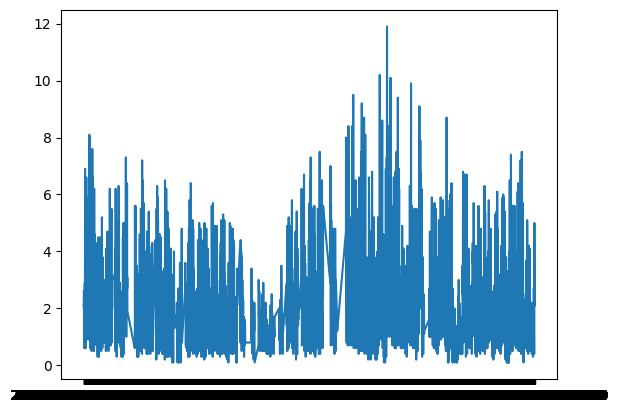

In [ ]:
# plotting aftering interplolation, to check for any abnormality

plt.figure()
plt.plot(df1["Datetime"],df1["CO(GT)"])
plt.figure()
plt.plot(df1["Datetime"],df1["NOx(GT)"])
plt.figure()
plt.plot(df1["Datetime"],df1["NO2(GT)"])

In [ ]:
# df3 =df1.cop()
# df3[['CO(GT)', 'NOx(GT)', 'NO2(GT)']] = df3[['CO(GT)', 'NOx(GT)', 'NO2(GT)']].interpolate(method='spline', order=2)
# giving a try to spline method

In [ ]:
# plt.figure()
# plt.plot(df3["Datetime"],df3["CO(GT)"])
# plt.figure()
# plt.plot(df3["Datetime"],df3["NOx(GT)"])
# plt.figure()
# plt.plot(df3["Datetime"],df3["NO2(GT)"])

In [ ]:
#  this wont be considered ahead as the graphs are very weird.

In [ ]:
# ill be using ARIMA/ARMA model to predict and since its univariate, ill need to do one by one, and for that ill need to make the data stationary
# the columns i think ill start with are:
# CO(GT)           CO conc
# NOx(GT)          nitric oxides cons - direclty effect air quality
# NO2(GT)          nitrogen dioxide - major pollutant
# C6H6(GT)         benzene - hazadious


In [21]:
df1 = df1.set_index("Datetime")

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [23]:
# decompostion = seasonal_decompose(df1["CO(GT)"],model="additive",period=24)
# decompostion.plot()

In [24]:
# checkign for stationarity

In [ ]:
# looking at the data it doesnt look like theres any seasonality. We can continue 
# with model building, but before ill check if its white noise.

In [26]:
def analyze_variable(series, name, period=24):
    print(f"=== Analyzing {name} ===")
    
    # ADF Test (Stationarity Check)
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    if result[1] > 0.05:
        print("→ Likely non-stationary.\n")
    else:
        print("→ Likely stationary.\n")
    
    # Seasonal Decomposition
    # decomposition = seasonal_decompose(series, model='additive', period=period)
    # decomposition.plot()
    # plt.suptitle(f"Seasonal Decomposition of {name}", fontsize=14)
    # plt.tight_layout()
    # plt.show()

In [27]:
for col in df1.columns:
    analyze_variable(df1[col], col)

=== Analyzing CO(GT) ===
ADF Statistic: -9.7791
p-value: 0.0000
→ Likely stationary.

=== Analyzing PT08.S1(CO) ===
ADF Statistic: -9.8228
p-value: 0.0000
→ Likely stationary.

=== Analyzing C6H6(GT) ===
ADF Statistic: -10.2482
p-value: 0.0000
→ Likely stationary.

=== Analyzing PT08.S2(NMHC) ===
ADF Statistic: -10.3517
p-value: 0.0000
→ Likely stationary.

=== Analyzing NOx(GT) ===
ADF Statistic: -7.3386
p-value: 0.0000
→ Likely stationary.

=== Analyzing PT08.S3(NOx) ===
ADF Statistic: -10.2053
p-value: 0.0000
→ Likely stationary.

=== Analyzing NO2(GT) ===
ADF Statistic: -8.2196
p-value: 0.0000
→ Likely stationary.

=== Analyzing PT08.S4(NO2) ===
ADF Statistic: -6.0564
p-value: 0.0000
→ Likely stationary.

=== Analyzing PT08.S5(O3) ===
ADF Statistic: -11.1184
p-value: 0.0000
→ Likely stationary.

=== Analyzing T ===
ADF Statistic: -2.8484
p-value: 0.0517
→ Likely non-stationary.

=== Analyzing RH ===
ADF Statistic: -7.8791
p-value: 0.0000
→ Likely stationary.

=== Analyzing AH ===
A

In [25]:
import seaborn as sns

def plot_correlation_heatmap(df):
    plt.figure(figsize=(10, 8))
    corr = df.corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title("Correlation Heatmap")
    plt.show()

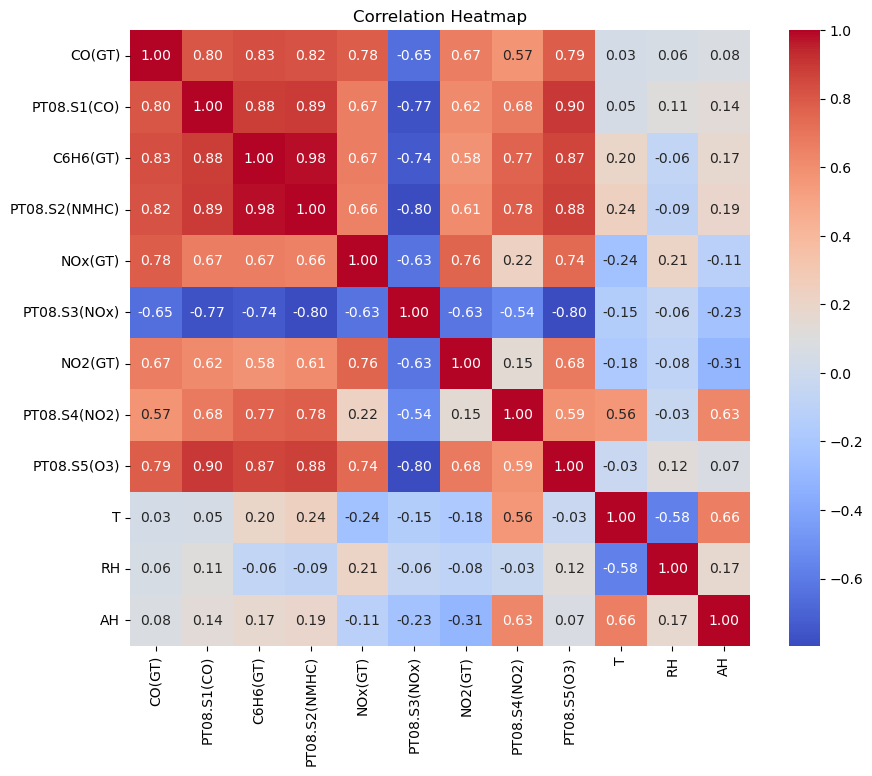

In [26]:
df_numeric = df1.select_dtypes(include=[np.number])
plot_correlation_heatmap(df_numeric)

In [27]:
df1.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)',
       'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH',
       'AH'],
      dtype='object')

In [28]:
data = df1.copy()
# since any VAR models requires stationery data and T is not stationery, we;ll diff it to make it stationery

In [29]:
data["T"]=data["T"].diff()
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

In [30]:
# Checking if T is now Stationary or not

In [31]:
af = adfuller(data["T"])
print(f"ADF Statistic: {af[0]:.4f}")
print(f"p-value: {af[1]:.4f}")
if af[1] > 0.05:
    print("→ Likely non-stationary.\n")
else:
    print("→ Likely stationary.\n")

ADF Statistic: -22.6009
p-value: 0.0000
→ Likely stationary.



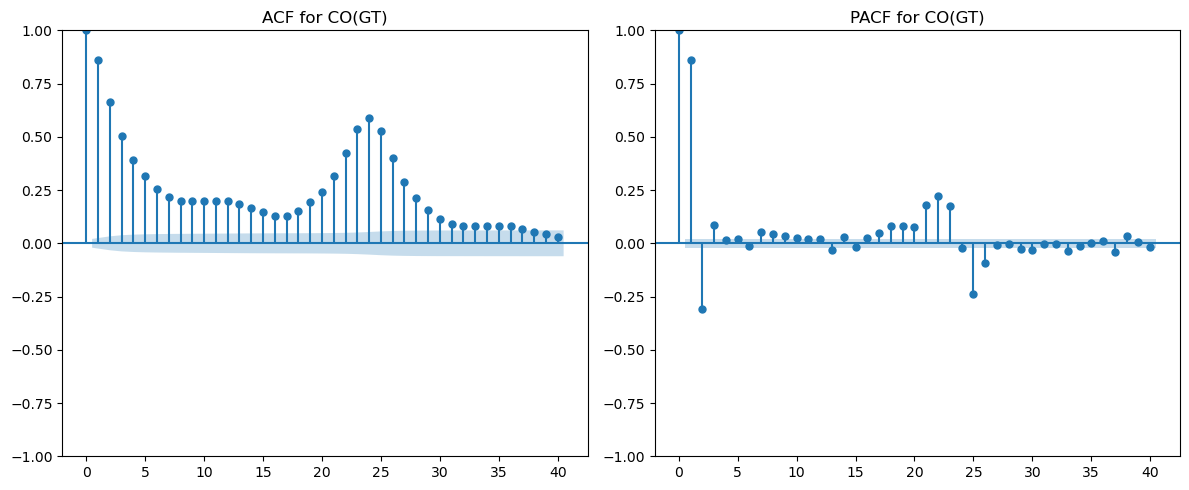

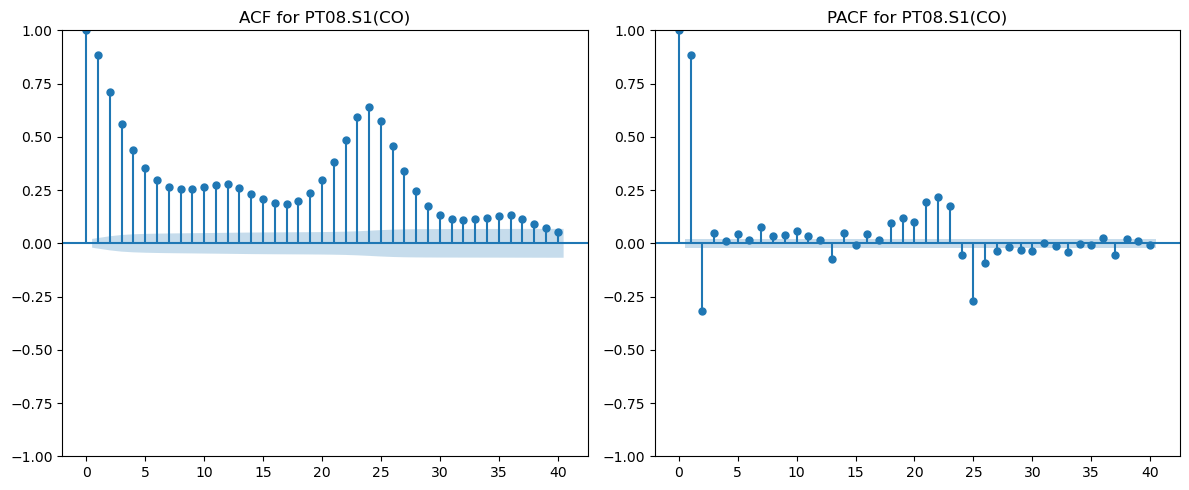

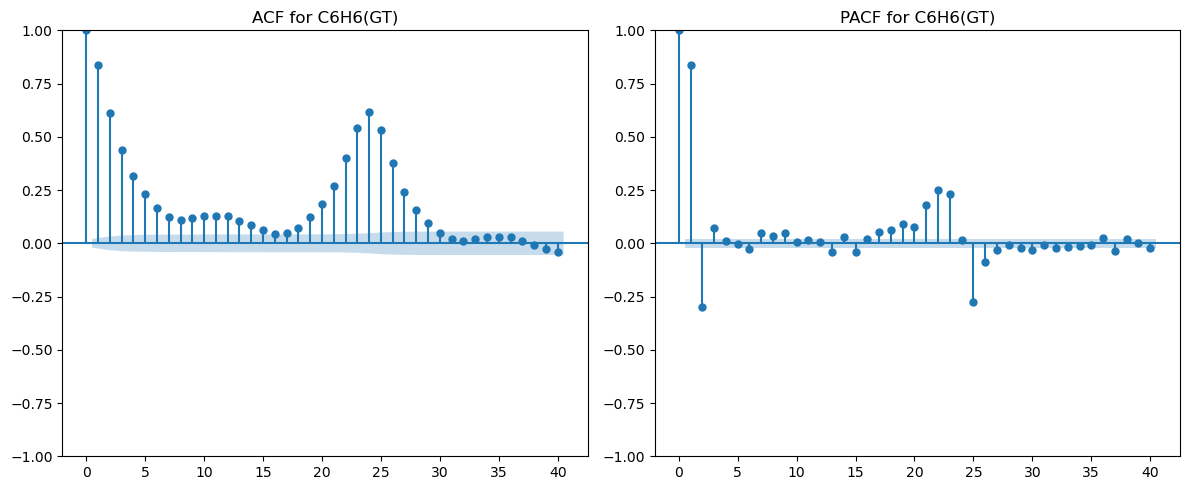

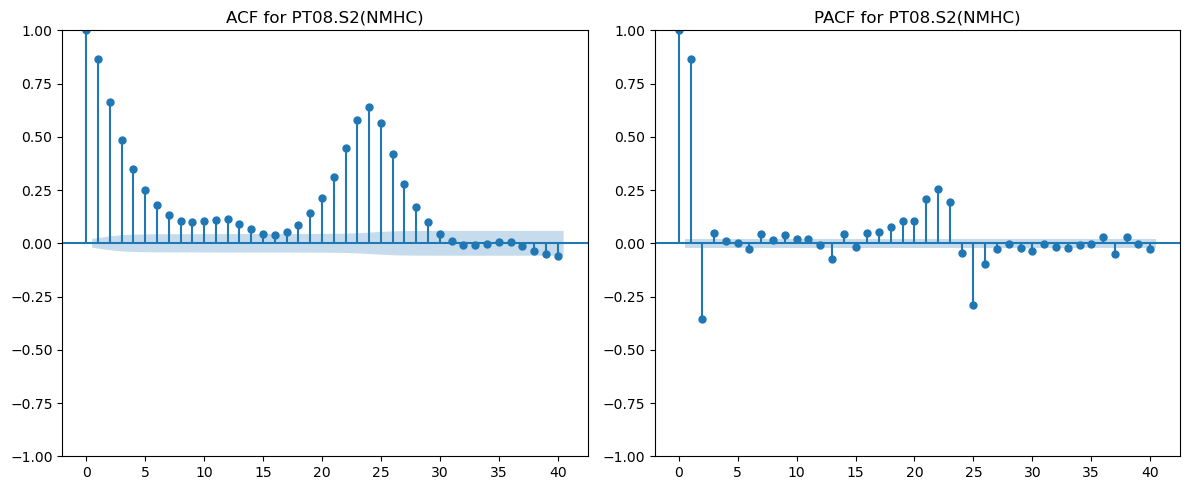

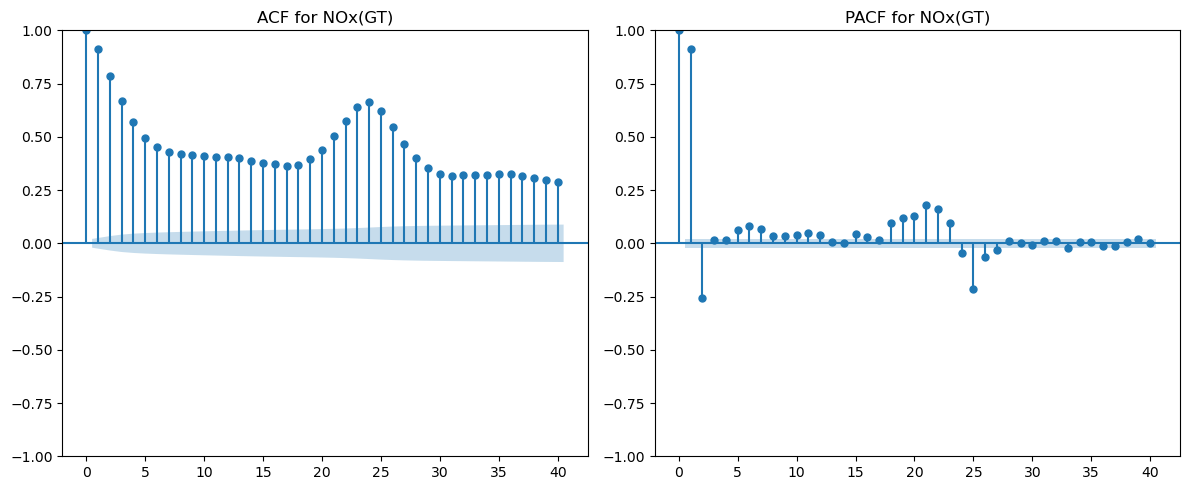

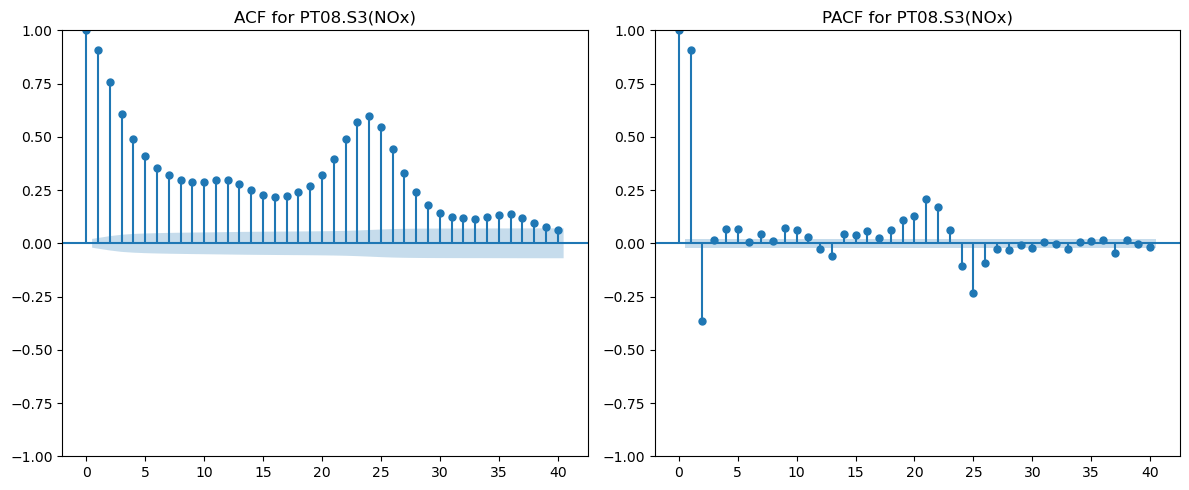

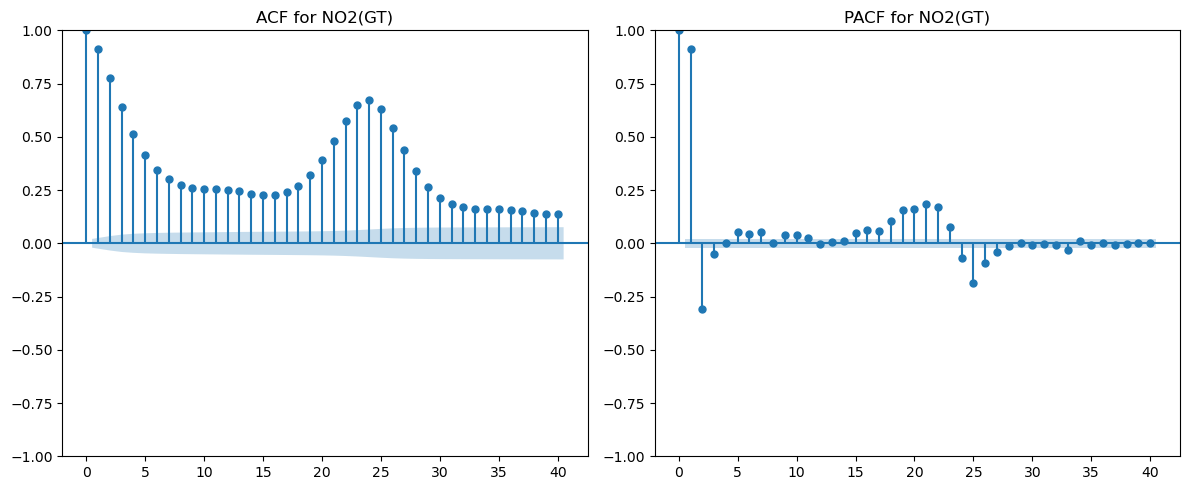

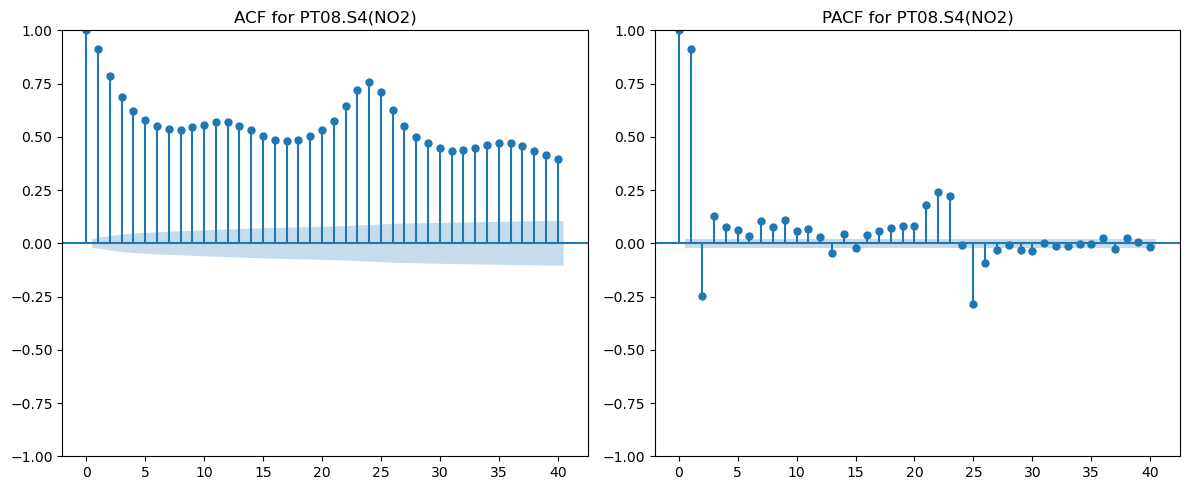

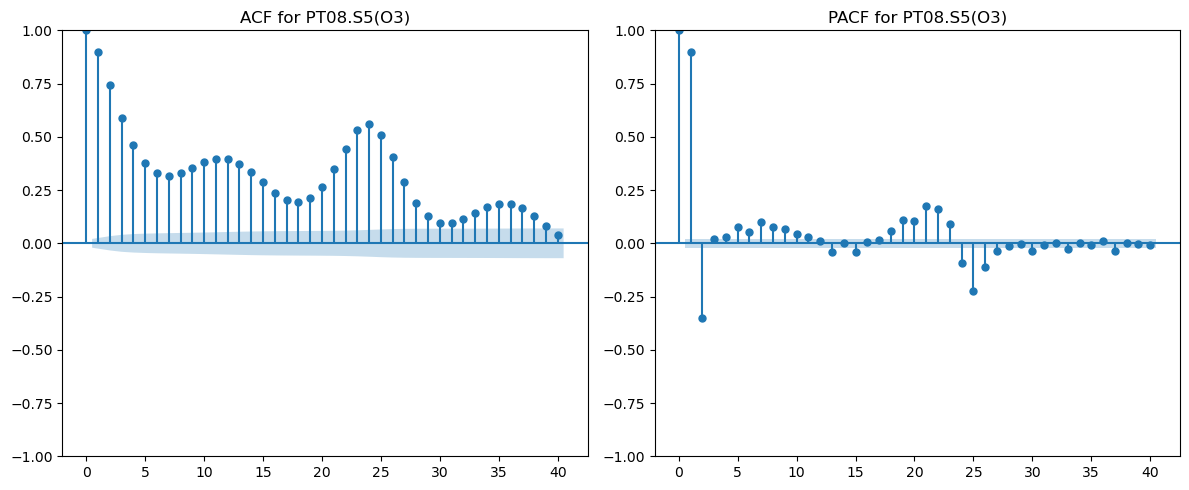

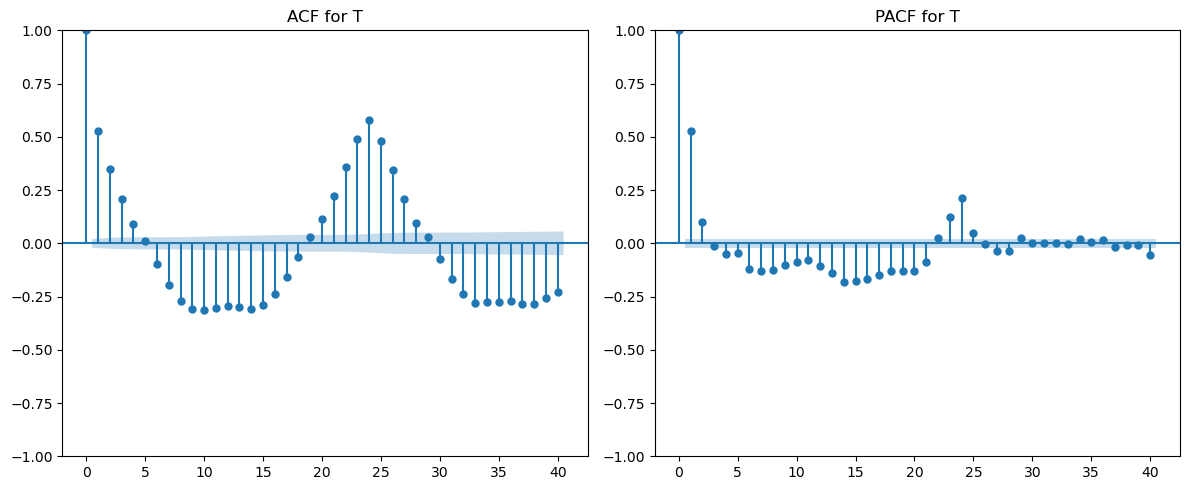

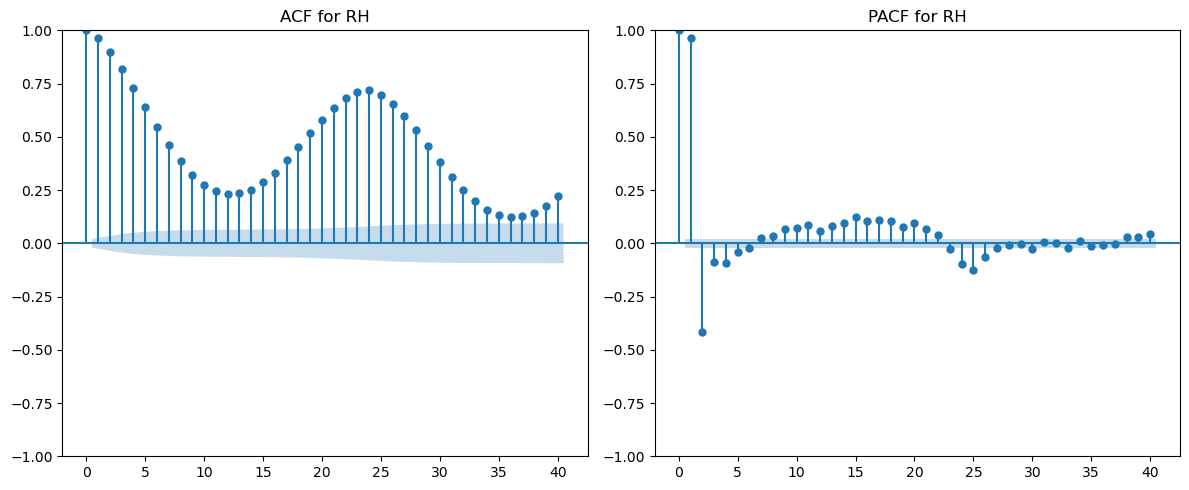

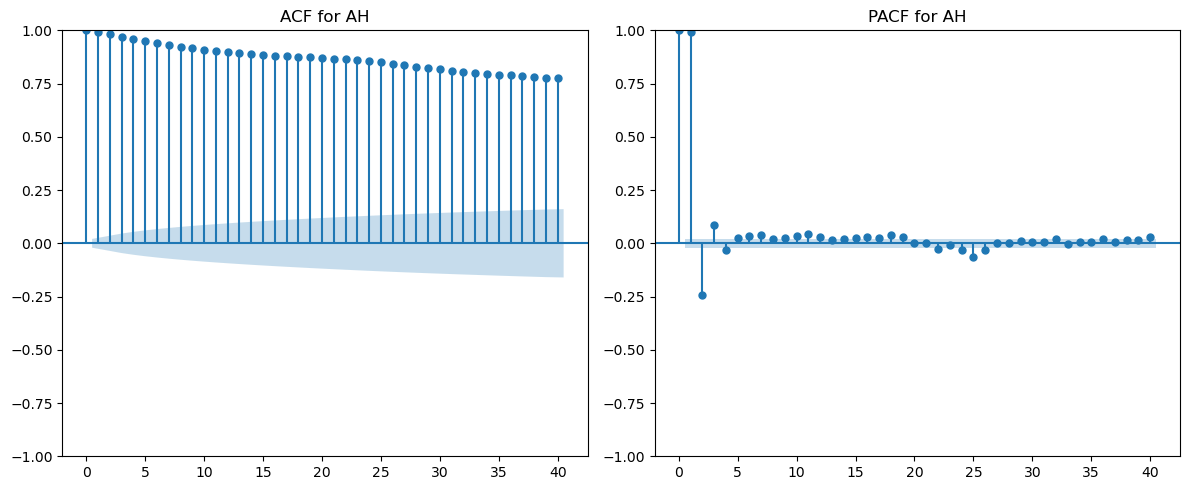

In [62]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

features = ['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)',
       'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH',
       'AH']

for col in features:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plot_acf(data[col], lags=40, ax=plt.gca(), title=f'ACF for {col}')

    plt.subplot(1, 2, 2)
    plot_pacf(data[col], lags=40, ax=plt.gca(), title=f'PACF for {col}', method='ywm')

    plt.tight_layout()
    plt.show()

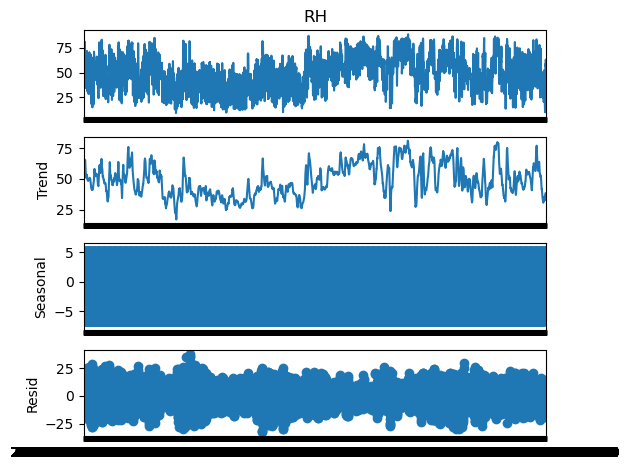

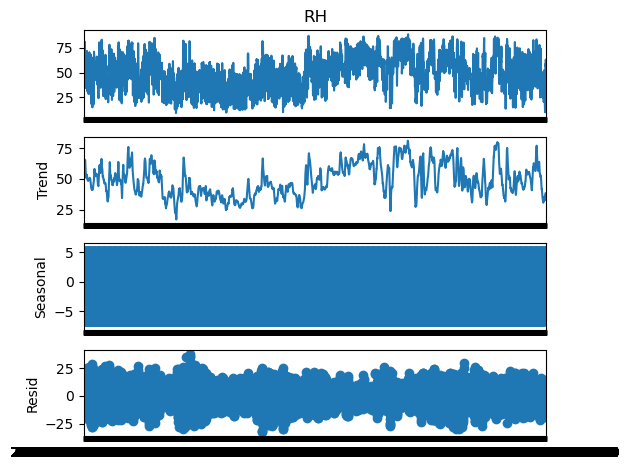

In [86]:
from statsmodels.tsa.seasonal import seasonal_decompose
df['RH_smooth'] = df['RH'].rolling(window=3, center=True).mean()
decompostion = seasonal_decompose(data["RH"],model="additive",period=24)
decompostion.plot()

In [ ]:
# The data contains 
endog_vars = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 
              'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 
              'PT08.S4(NO2)', 'PT08.S5(O3)']

exog_vars = ['T', 'RH', 'AH']

exog_forecasts = {}
exog_rmses = {}

# splitting into train and test
n = len(data)
train_end = int(0.9 * n)
forecast_horizon = 48 

train_data = data.iloc[:train_end]
test_data = data.iloc[train_end:train_end+forecast_horizon]


In [34]:
# using SARIMA for 'T', 'RH' (seasonality exists) and ARIMA for AH (no seasonality)

from statsmodels.tsa.statespace.sarimax import SARIMAX


model_T = SARIMAX(train_data['T'], order=(2, 2, 1), seasonal_order=(1, 1, 1, 24))
results_T = model_T.fit()
forecast_T = results_T.forecast(steps=forecast_horizon)
exog_forecasts["T"] = forecast_T.values

# RH
model_RH = SARIMAX(train_data['RH'], order=(1, 2, 0), seasonal_order=(1, 1, 1, 24))
results_RH = model_RH.fit()
forecast_RH = results_RH.forecast(steps=forecast_horizon)
exog_forecasts["RH"] = forecast_RH.values






/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87084D+00    |proj g|=  1.97129D-01


 This problem is unconstrained.



At iterate    5    f=  1.66354D+00    |proj g|=  1.24944D-01

At iterate   10    f=  1.63741D+00    |proj g|=  8.82034D-03

At iterate   15    f=  1.62587D+00    |proj g|=  6.99932D-02

At iterate   20    f=  1.61867D+00    |proj g|=  1.43225D-02

At iterate   25    f=  1.61694D+00    |proj g|=  2.48247D-03

At iterate   30    f=  1.61672D+00    |proj g|=  1.84358D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     55      1     0     0   1.411D-03   1.617D+00
  F =   1.6166997845265063     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.10216D+00    |proj g|=  7.06406D-02

At iterate    5    f=  2.97707D+00    |proj g|=  8.43297D-03

At iterate   10    f=  2.97677D+00    |proj g|=  7.99818D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   9.981D-06   2.977D+00
  F =   2.9767726199014510     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [118]:
model_AH = ARIMA(train_data["AH"], order=(1, 2, 0))  
results_AH = model_AH.fit()
forecast_AH = results_AH.forecast(steps=forecast_horizon)
exog_forecasts["AH"] = forecast_AH.values

In [119]:
# # forcasting the exogenous features 

# for var in exog_vars:
    
#     # Fit ARIMA model
#     model = ARIMA(train_data[var], order=(3,0,2))  # Tune order as needed
#     model_fit = model.fit()

#     # Forecast 48 hours
#     forecast = model_fit.forecast(steps=forecast_horizon)

#     # Store forecast
#     exog_forecasts[var] = forecast.values

# # import pmdarima as pm

# # # Dictionary to store best models
# # best_orders = {}

# # for var in exog_vars:
# #     series = train_data[var]

# #     # Auto ARIMA with AIC scoring
# #     model = pm.auto_arima(series, 
# #                           seasonal=False,  # Set True if you suspect seasonality
# #                           trace=True,      # Print the progress
# #                           error_action='ignore',  
# #                           suppress_warnings=True,
# #                           max_p=5, max_q=5, d=None,  # You can increase max_p/q if needed
# #                           stepwise=True)

# #     print(f'Best order for {var}: {model.order}')
# #     best_orders[var] = model.order

# #     # Fit model again with best order if you want
# #     forecast = model.predict(n_periods=forecast_horizon)
# #     exog_forecasts[var] = forecast


In [120]:
future_index = data.index[train_end:train_end+forecast_horizon]
future_exog = pd.DataFrame(exog_forecasts, index=future_index)

In [121]:
actual_T = test_data['T'][:forecast_horizon]
rmse_T = np.sqrt(mean_squared_error(actual_T, forecast_T))
exog_rmses["T"] = rmse_T

actual_RH = test_data['RH'][:forecast_horizon]
rmse_RH = np.sqrt(mean_squared_error(actual_RH, forecast_RH))
exog_rmses["RH"] = rmse_RH

actual_AH = test_data['AH'][:forecast_horizon]
rmse_AH = np.sqrt(mean_squared_error(actual_AH, forecast_AH))
exog_rmses["AH"] = rmse_AH

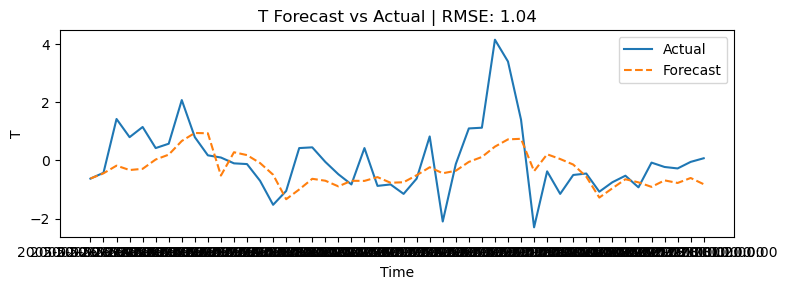

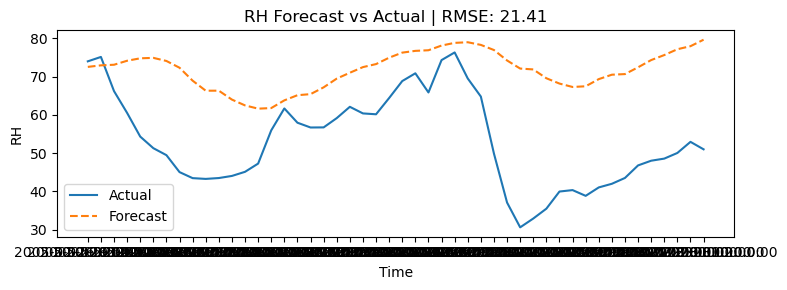

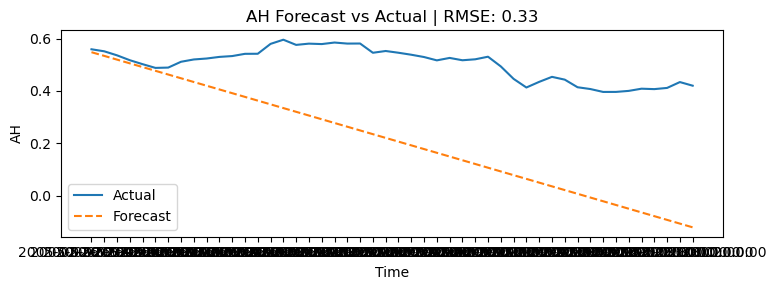

In [122]:
for var in exog_vars:
    actual = test_data[var].values[:forecast_horizon]
    predicted = exog_forecasts[var]
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    exog_rmses[var] = rmse

    plt.figure(figsize=(8, 3))
    plt.plot(future_index, actual, label='Actual')
    plt.plot(future_index, predicted, label='Forecast', linestyle='--')
    plt.title(f"{var} Forecast vs Actual | RMSE: {rmse:.2f}")
    plt.xlabel("Time")
    plt.ylabel(var)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [123]:

# combining
future_exog = pd.DataFrame(exog_forecasts, index=future_index)

print("\n🔍 Forecasted Exogenous Data (48 hrs):")
print(future_exog.head())

print("\n📉 RMSE of Exogenous Forecasts:")
for var, score in exog_rmses.items():
    print(f"{var}: {score:.2f}")



🔍 Forecasted Exogenous Data (48 hrs):
                            T         RH        AH
Datetime                                          
2005-02-26 03:00:00 -0.621613  72.525412  0.547943
2005-02-26 04:00:00 -0.442308  72.927302  0.533832
2005-02-26 05:00:00 -0.178744  73.086020  0.519556
2005-02-26 06:00:00 -0.330086  74.130175  0.505334
2005-02-26 07:00:00 -0.288086  74.766130  0.491094

📉 RMSE of Exogenous Forecasts:
T: 1.04
RH: 21.41
AH: 0.33


In [35]:

train_endog = train_data[endog_vars]
train_exog = train_data[exog_vars]
print("Data types in train_data:")
print(train_data[endog_vars].dtypes)
print(train_data[exog_vars].dtypes)

Data types in train_data:
CO(GT)           float64
C6H6(GT)         float64
NOx(GT)          float64
NO2(GT)          float64
PT08.S1(CO)      float64
PT08.S2(NMHC)    float64
PT08.S3(NOx)     float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
dtype: object
T     float64
RH    float64
AH    float64
dtype: object


In [36]:
print("NaNs in endog:", train_data[endog_vars].isna().sum().sum())
print("NaNs in exog:", train_data[exog_vars].isna().sum().sum())
print("NaNs in future_exog:", future_exog.isna().sum().sum())

NaNs in endog: 0
NaNs in exog: 0


NameError: name 'future_exog' is not defined

In [ ]:
 # fiitng VARMAX  an forcasting
model = VARMAX(train_data[endog_vars], exog=train_data[exog_vars], order=(2, 0))
model_fit = model.fit(maxiter=100, disp=False)

forecasted_endog = model_fit.forecast(steps=forecast_horizon, exog=future_exog)

print("Forecasted Endogenous Variables (first 5 rows):")
print(forecasted_endog.head())

In [ ]:
rmse_per_feature = {}
for feature in forecasted_endog.columns:
    actual_values = test_data[feature][:forecast_horizon]  # Actual values
    predicted_values = forecasted_endog[feature]           # Forecasted values
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    rmse_per_feature[feature] = rmse

# Print RMSE for each feature
print("RMSE for Endogenous Features:")
for feature, rmse in rmse_per_feature.items():
    print(f"{feature}: {rmse:.2f}")

In [ ]:
# train_size = int(len(data) * 0.9)
# train, test = data[:train_size], data[train_size:]

# train.shape, test.shape

In [ ]:
# from statsmodels.tsa.api import VAR
# from statsmodels.tsa.stattools import adfuller

In [30]:
data1 = df2.copy()
lags = [1, 2, 3, 6, 12, 24]  # Creating lags for 1 hour, 2 hours, etc.

for col in data1.columns:
    for lag in lags:
        data1[f'{col}_lag_{lag}'] = data1[col].shift(lag)

# Drop rows with NaN values (resulting from lag creation)
data1 = data1.dropna()

# Check the data after lag feature creation
data1.head()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,...,RH_lag_3,RH_lag_6,RH_lag_12,RH_lag_24,AH_lag_1,AH_lag_2,AH_lag_3,AH_lag_6,AH_lag_12,AH_lag_24
Datetime,,,,,,,,,,,,,,,,,,,,,
2004-03-11 18:00:00,4.8,1580.75,20.799217,1318.50,281.0,798.50,151.0,2083.00,1408.50,10.350,...,79.799999,66.774999,58.125000,48.875001,0.818501,0.856938,0.877784,0.795054,0.735295,0.757754
2004-03-11 19:00:00,6.9,1775.50,27.359807,1487.75,383.0,702.25,172.0,2332.50,1704.00,9.650,...,71.150002,76.425001,59.599999,47.700000,0.806544,0.818501,0.856938,0.839268,0.741736,0.725487
2004-03-11 20:00:00,6.1,1640.00,24.017757,1404.00,351.0,742.75,165.0,2191.25,1653.75,9.650,...,67.624998,81.150000,57.425000,53.975000,0.831921,0.806544,0.818501,0.873589,0.740795,0.750239
2004-03-11 21:00:00,3.9,1312.75,12.779368,1076.25,240.0,957.25,136.0,1706.50,1284.75,9.125,...,64.174999,79.799999,60.599998,60.000000,0.813314,0.831921,0.806544,0.877784,0.769111,0.786713
2004-03-11 22:00:00,1.5,964.50,4.707072,748.50,94.0,1325.25,85.0,1332.50,821.00,8.175,...,69.300001,71.150002,58.350000,59.575001,0.741924,0.813314,0.831921,0.856938,0.755183,0.788794


In [33]:
train_size = int(len(data1) * 0.9)
train, test = data1[:train_size], data1[train_size:]

# Separate features (X) and target (y) for both train and test sets
X_train = train.drop(columns=['CO(GT)', 'NOx(GT)', 'NO2(GT)'])
y_train = train[['CO(GT)', 'NOx(GT)', 'NO2(GT)']]

X_test = test.drop(columns=['CO(GT)', 'NOx(GT)', 'NO2(GT)'])
y_test = test[['CO(GT)', 'NOx(GT)', 'NO2(GT)']]

In [34]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

model = XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=6, n_jobs=-1)

# Train the model on the training data
model.fit(X_train, y_train)

# Predict for test set
y_pred = model.predict(X_test)

# Calculate RMSE for each feature
rmse_per_feature = np.sqrt(np.mean((y_test - y_pred)**2, axis=0))

# Print RMSE for each feature
for i, rmse in enumerate(rmse_per_feature):
    print(f"Feature {i + 1} RMSE: {rmse}")

Feature 1 RMSE: 0.28667223866729713
Feature 2 RMSE: 49.203572533147494
Feature 3 RMSE: 12.355668027187196


In [ ]:
# model = VAR(train)
# lag_order = model.select_order(maxlags=15).aic
# print("Optimal Lag Order:", lag_order)
# var_model = model.fit(lag_order)
# var_model.summary()

In [ ]:
# forecast_steps = 48
# forecast = var_model.forecast(train.values[-lag_order:], steps=forecast_steps)
# forecast_df1 = pd.DataFrame(forecast, columns=train.columns, index=test.index[:forecast_steps])
# forecast_df1.head()

In [ ]:
# from sklearn.metrics import mean_squared_error
# import numpy as np
# forecast_steps = 48
# forecast = var_model.forecast(train.values[-lag_order:], steps=forecast_steps)

# forecast_df = pd.DataFrame(forecast, columns=train.columns, index=test.index[:forecast_steps])
# rmse_per_feature = {}
# for feature in forecast_df.columns:
#     actual_values = test[feature][:forecast_steps]  # Actual values from the test set
#     predicted_values = forecast_df[feature]  # Predicted values from the forecast
#     rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
#     rmse_per_feature[feature] = rmse


# for feature, rmse in rmse_per_feature.items():
#     print(f"RMSE for {feature}: {rmse}")

In [ ]:

# 1. RMSE value for CO(GT) is <= 10
# 2. RMSE value for PT08.S1(CO) is <= 210
# 3. RMSE value for NMHC(GT) is <= 14
# 4. RMSE value for C6H6(GT) is <= 6
# 5. RMSE value for PT08.S2(NMHC) is <= 250
# 6. RMSE value for NOx(GT) is <= 190
# 7. RMSE value for PT08.S3(NOx) is <= 196.0619
# 8. RMSE value for NO2(GT) is <= 120
# 9. RMSE value for PT08.S4(NO2) is <= 300.7
# 10. RMSE value for PT08.S5(O3) is <= 400.25
# 11. RMSE value for Temperature is <= 12
# 12. RMSE value for Relative Humidity is <= 18
# 13. RMSE value for Absolute Humidity is <= 7


In [ ]:
model = VAR(data)
lag_selection = model.select_order(maxlags=30)  # checking for lag selection
print(lag_selection.summary())

In [ ]:
# AIC and BIC suggest a very high value of lag, this will cause overfitting and hence im not using this method plus my 
# data has exogenous features hence its not good to use this

In [ ]:
# working on LSTM approach

In [34]:
data2=df1.copy()
data2["T"]=data2["T"].diff()
data2.replace([np.inf, -np.inf], np.nan, inplace=True)
data2.dropna(inplace=True)

In [35]:
features = data2.columns
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data2)
scaled_df = pd.DataFrame(scaled, columns=features)

In [36]:
# creating sequence for multivar LSTM
def create_sequences(data, window=24, forecast_horizon=48):
    X, y = [], []
    for i in range(len(data) - window - forecast_horizon + 1):
        X.append(data[i:i + window])
        y.append(data[i + window:i + window + forecast_horizon])
    return np.array(X), np.array(y)

In [37]:
window_size = 24
forecast_horizon = 48
X, y = create_sequences(scaled_df.values, window_size, forecast_horizon)

In [38]:
train_size = int(0.9 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [39]:
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=False, input_shape=(window_size, len(features))),
    Dense(forecast_horizon * len(features)),
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train.reshape((y_train.shape[0], -1)), epochs=10, batch_size=32, verbose=1)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0384
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0145
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0125
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0116
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0114
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0108
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0107
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0104
Epoch 9/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0101
Epoch 10/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0097


In [40]:
y_pred = model.predict(X_test)
y_pred = y_pred.reshape((y_pred.shape[0], forecast_horizon, len(features)))


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [41]:
y_pred_inv = scaler.inverse_transform(y_pred[-1])
y_test_inv = scaler.inverse_transform(y_test[-1])

In [42]:
for i, col in enumerate(features):
    rmse = np.sqrt(mean_squared_error(y_test_inv[:, i], y_pred_inv[:, i]))
    print(f"RMSE for {col}: {rmse:.3f}")

RMSE for CO(GT): 0.989
RMSE for PT08.S1(CO): 135.451
RMSE for C6H6(GT): 4.812
RMSE for PT08.S2(NMHC): 182.401
RMSE for NOx(GT): 183.017
RMSE for PT08.S3(NOx): 133.748
RMSE for NO2(GT): 35.962
RMSE for PT08.S4(NO2): 161.676
RMSE for PT08.S5(O3): 409.894
RMSE for T: 1.623
RMSE for RH: 11.720
RMSE for AH: 0.132



Autocorrelation of Residuals for CO(GT):


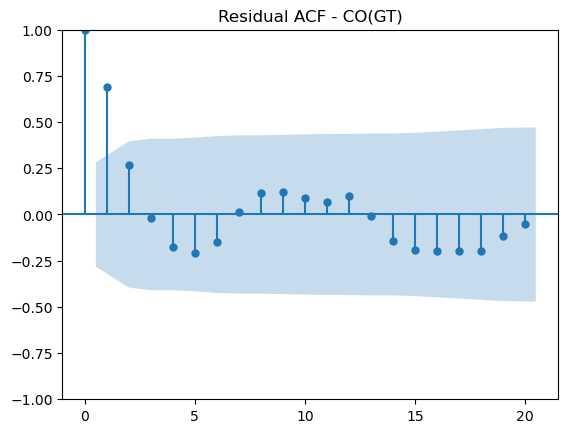


Autocorrelation of Residuals for PT08.S1(CO):


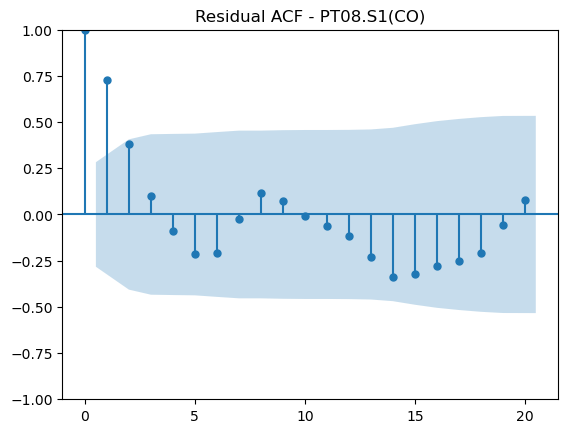


Autocorrelation of Residuals for C6H6(GT):


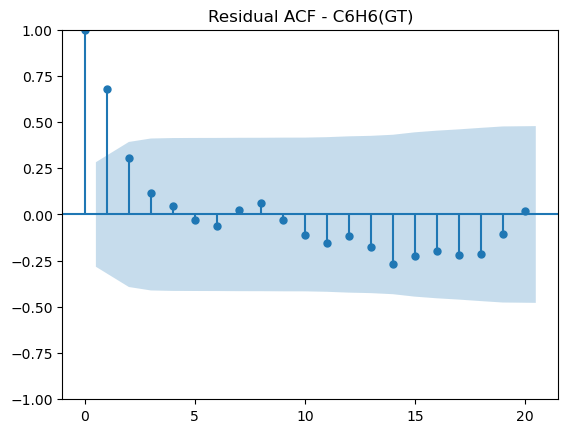


Autocorrelation of Residuals for PT08.S2(NMHC):


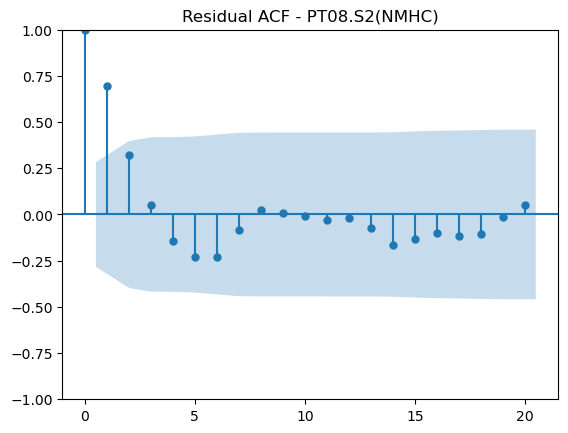


Autocorrelation of Residuals for NOx(GT):


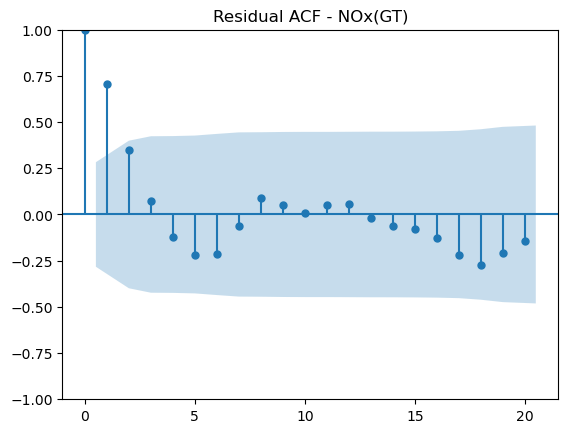


Autocorrelation of Residuals for PT08.S3(NOx):


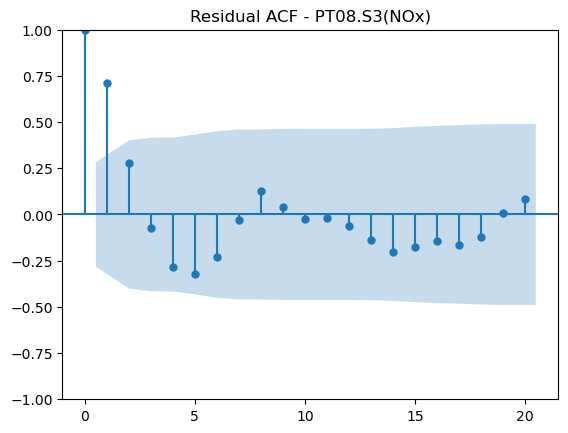


Autocorrelation of Residuals for NO2(GT):


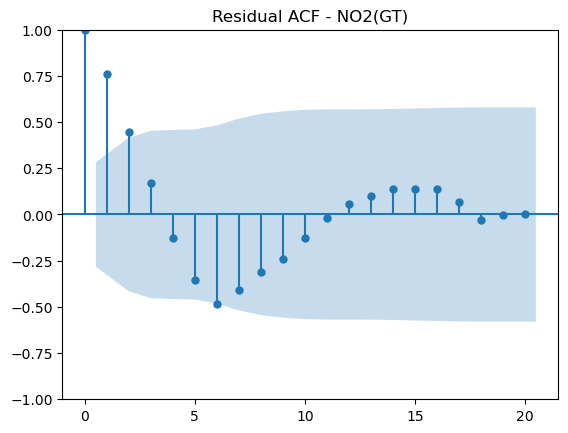


Autocorrelation of Residuals for PT08.S4(NO2):


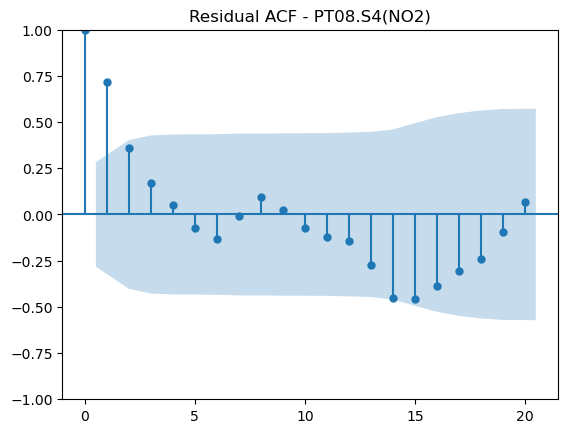


Autocorrelation of Residuals for PT08.S5(O3):


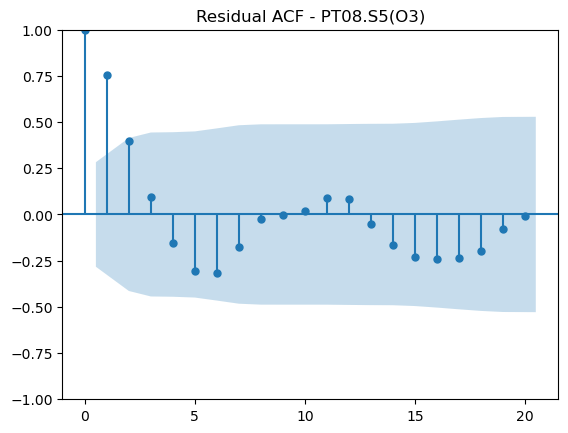


Autocorrelation of Residuals for T:


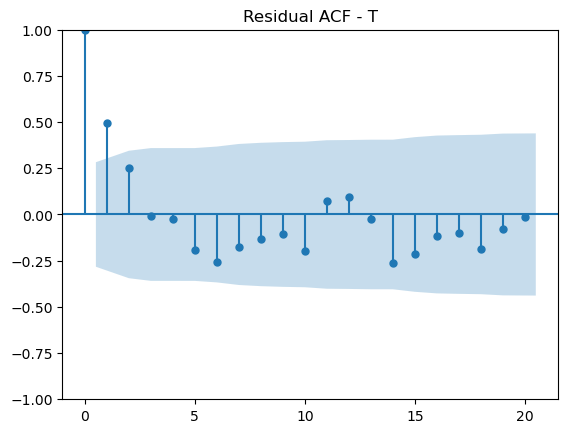


Autocorrelation of Residuals for RH:


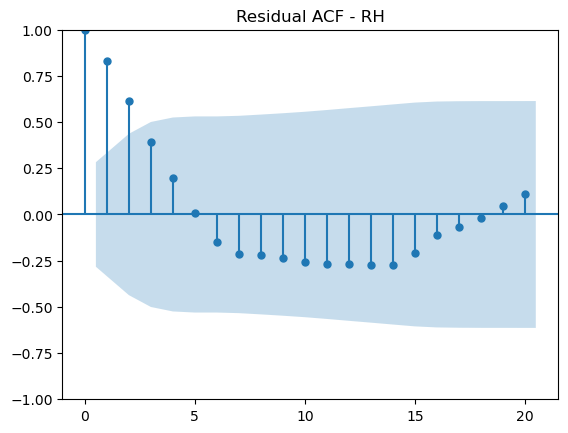


Autocorrelation of Residuals for AH:


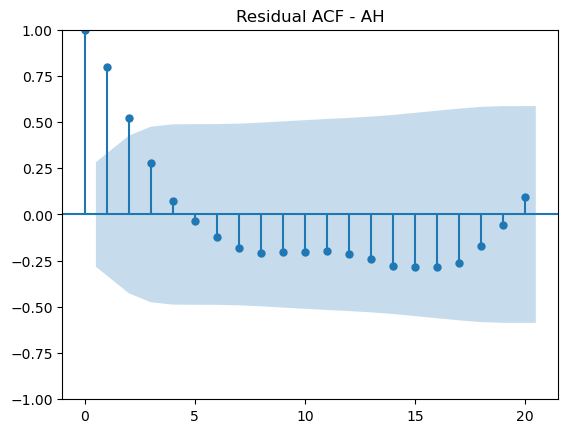

In [43]:
residuals = y_test_inv - y_pred_inv
for i, col in enumerate(features):
    print(f"\nAutocorrelation of Residuals for {col}:")
    plot_acf(residuals[:, i], lags=20)
    plt.title(f'Residual ACF - {col}')
    plt.show()

In [ ]:

a

In [48]:
last_row = data2.iloc[-1]
print(last_row)

CO(GT)              2.200000
PT08.S1(CO)      1070.750000
C6H6(GT)           11.932060
PT08.S2(NMHC)    1047.250000
NOx(GT)           265.200000
PT08.S3(NOx)      654.000000
NO2(GT)           167.700000
PT08.S4(NO2)     1128.500000
PT08.S5(O3)       816.000000
T                   0.175001
RH                 13.125000
AH                  0.502804
Name: 2005-04-04 14:00:00, dtype: float64


In [49]:
import pandas as pd
import numpy as np

last_time = pd.to_datetime('2005-04-04 14:00:00') 
date_range = pd.date_range(start=last_time, periods=49, freq='H')[1:]  #  to generate the next 48 hours from the last time step
times = date_range.time

columns = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 
           'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# Flattening the predictions and actual values
y_pred_flat = y_pred_inv.reshape(-1, len(features))
y_test_flat = y_test_inv.reshape(-1, len(features))


df_pred = pd.DataFrame(y_pred_flat, columns=[f'Predicted_{feature}' for feature in features])
# df_pred['Predicted_NMHC(GT)'] = 0   did not predict this

df = pd.DataFrame({
    'Date': date_range.date,
    'Time': times,
    'CO(GT)': df_pred['Predicted_CO(GT)'],
    'PT08.S1(CO)': df_pred['Predicted_PT08.S1(CO)'],
    'NMHC(GT)': df_pred['Predicted_NMHC(GT)'],  # This column will have 0s since i didnt predict
    'C6H6(GT)': df_pred['Predicted_C6H6(GT)'],
    'PT08.S2(NMHC)': df_pred['Predicted_PT08.S2(NMHC)'],
    'NOx(GT)': df_pred['Predicted_NOx(GT)'],
    'PT08.S3(NOx)': df_pred['Predicted_PT08.S3(NOx)'],
    'NO2(GT)': df_pred['Predicted_NO2(GT)'],
    'PT08.S4(NO2)': df_pred['Predicted_PT08.S4(NO2)'],
    'PT08.S5(O3)': df_pred['Predicted_PT08.S5(O3)'],
    'T': df_pred['Predicted_T'],
    'RH': df_pred['Predicted_RH'],
    'AH': df_pred['Predicted_AH']
})


df.to_excel('LSTM_results_48hours_formatted.xlsx', index=False)
